In [1]:
import pandas as pd
import numpy as np
import re
from sklearn import metrics
from sklearn.metrics import classification_report

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
race_df = pd.read_csv('/content/drive/MyDrive/CS640/final_project/preprocessed_race_tweets.csv')
# race_df = pd.read_csv('./data/preprocessed_race_tweets.csv')

In [4]:
race_df.columns

Index(['Unnamed: 0', 'text', 'label', 'user_id'], dtype='object')

In [5]:
race_df['label'].value_counts()

0.0    224287
1.0     26269
3.0     16292
2.0      9189
Name: label, dtype: int64

sample 10000 data from each label

In [6]:
freq = pd.DataFrame({'label':[0, 1, 2, 3],
                     'nostoextract':[6000, 10000, 6000, 6000], })

def bootstrap(data, freq):
    freq = freq.set_index('label')

    # This function will be applied on each group of instances of the same
    # class in `data`.
    def sampleClass(classgroup):
        cls = classgroup['label'].iloc[0]
        nDesired = freq.nostoextract[cls]
        nRows = len(classgroup)

        nSamples = min(nRows, nDesired)
        return classgroup.sample(nSamples)

    samples = data.groupby('label').apply(sampleClass)

    # If you want a new index with ascending values
    # samples.index = range(len(samples))

    # If you want an index which is equal to the row in `data` where the sample
    # came from
    samples.index = samples.index.get_level_values(1)

    # If you don't change it then you'll have a multiindex with level 0
    # being the class and level 1 being the row in `data` where
    # the sample came from.

    return samples

train_race_df = bootstrap(race_df,freq)


In [7]:
len(train_race_df)

28000

In [8]:
test_race_df = race_df.drop(index = train_race_df.index, axis = 0)
test_freq = pd.DataFrame({'label':[0, 1, 2, 3],
                     'nostoextract':[3000, 3000, 3000, 3000], })
test_race_df = bootstrap(race_df,test_freq)
len(test_race_df)

12000

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(train_race_df['text'], train_race_df['label'], test_size=0.3, stratify=train_race_df['label'])

In [32]:
X_train

166870                              wish was such bad place
155375    easy post someone tweet without engaging them ...
217832    live come pull chair and entertained hell lets...
71399        naaaaaa buggin this the best pizza spot jersey
98905                        enter win  tiny mattresses one
                                ...                        
206328                 want love you but not right what can
87959     wanted one for long wanted the one that happen...
275313                                      gonna die young
35913     ahahn but you know you premium demon spawn thi...
109337                   happy birthday billie joe amstrong
Name: text, Length: 19600, dtype: object

### Race prediction using pre-trained BERT model

In [10]:
!pip install transformers
!pip insrall torch

     |████████████████████████████████| 3.1 MB 4.2 MB/s 
     |████████████████████████████████| 61 kB 609 kB/s 
     |████████████████████████████████| 3.3 MB 57.2 MB/s 
     |████████████████████████████████| 895 kB 60.8 MB/s 
     |████████████████████████████████| 596 kB 61.4 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
ERROR: unknown command "insrall" - maybe you meant "install"


In [11]:
import transformers
import torch
import torch.nn as nn
from transformers import AutoModel, BertTokenizerFast

In [12]:
# import BERT-base pretrained model
bert = AutoModel.from_pretrained('bert-base-cased', return_dict=False)
# Load the BERT tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-cased')

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/416M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

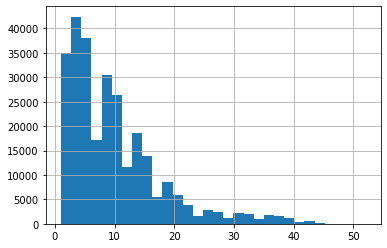

In [14]:
# get length of all the messages in the train set
seq_len = [len(i.split()) for i in race_df['text']]
pd.Series(seq_len).hist(bins = 30)

In [13]:
# tokenize and encode sequences in the training set
tokens_train = tokenizer.batch_encode_plus(
    X_train.tolist(), 
    max_length = 20,
    padding='max_length', 
    truncation=True,

)

In [14]:
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    X_val.tolist(), 
    max_length = 20,
    padding='max_length', 
    truncation=True,

)

In [15]:
# tokenize and encode sequences in the test set
tokens_test = tokenizer.batch_encode_plus(
    test_race_df['text'].tolist(),
    max_length = 20,
    padding='max_length',
    truncation=True,

)

In [16]:
# Formatting Ys turn [0, 1, 2, 0, 1, 1] to [[1,0,0], [0,1,0], [0, 0, 1], ...]
def label_y2mat(y_ls):
    y_mat = np.zeros((len(y_ls), 4))

    for idx, v in enumerate(y_ls):
        v = int(v)
        y_mat[idx][v] = 1

    return y_mat

In [17]:
## convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(label_y2mat(y_train.tolist()), dtype=torch.float32)
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(label_y2mat(y_val.tolist()), dtype=torch.float32)
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(label_y2mat(test_race_df['label'].tolist()), dtype=torch.float32)

In [18]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
#define a batch size
batch_size = 8
# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)
# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)
# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)
# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)
# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [19]:
from sklearn.utils.class_weight import compute_class_weight
#compute the class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y = y_train)
print("Class Weights:",class_weights)


Class Weights: [1.16666667 0.7        1.16666667 1.16666667]


In [20]:
# converting list of class weights to a tensor
weights= torch.tensor(class_weights,dtype=torch.float)
# number of training epochs
epochs = 6

In [21]:
class BERT_Arch(nn.Module):
    def __init__(self, bert, n_classes: int,):
        super(BERT_Arch, self).__init__()
        self.bert = bert 
        # dropout layer
        self.dropout = nn.Dropout(0.4)
        self.fc1 = nn.Linear(768, self.bert.config.hidden_size)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.sigmoid = nn.Sigmoid()
        self.criterion = nn.BCELoss(weight=weights)

        
        
    # define the forward pass    
    def forward(self, sent_id, mask, labels = None):
        _, cls_hs = self.bert(sent_id, attention_mask=mask)
        x = self.fc1(cls_hs)
        x = self.dropout(x)
        x = self.out(x)
        x = self.sigmoid(x)
        return x


In [22]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert, 4)
# push the model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [23]:
# optimizer from hugging face transformers
from transformers import AdamW
# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-5, weight_decay=1e-5)      

In [24]:
# function to train the model
def train():
    model.train()
    total_loss, total_accuracy = 0, 0
    # empty list to save model predictions
    total_preds=[]
    # iterate over batches
    for step,batch in enumerate(train_dataloader):
        # progress update after every 50 batches.
        if step % 100 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
        
        # push the batch to gpu
        batch = [r.to(device) for r in batch]
        sent_id, mask, labels = batch
        # clear previously calculated gradients 
        model.zero_grad()        
        
        # get model predictions for the current batch
        preds = model(sent_id, mask)
        # compute the loss between actual and predicted values

        loss = model.criterion(preds, labels)

        # add on to the total loss
        total_loss += loss.item()
        
        # backward pass to calculate the gradients
        loss.backward()
        
        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # update parameters
        optimizer.step()
        # model predictions are stored on GPU. So, push it to CPU
        preds=preds.detach().cpu().numpy()
        # append the model predictions
        total_preds.append(preds)
        
        
    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)
    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)
    #returns the loss and predictions
    return avg_loss, total_preds

In [25]:
# function for evaluating the model
def evaluate():
    print("\nEvaluating...")
    # deactivate dropout layers
    model.eval()
    total_loss, total_accuracy = 0, 0
    # empty list to save the model predictions
    total_preds = []
    # iterate over batches
    for step,batch in enumerate(val_dataloader):
        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            #elapsed = format_time(time.time() - t0)
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
        # push the batch to gpu
        batch = [t.to(device) for t in batch]
        sent_id, mask, labels = batch
        # deactivate autograd
        with torch.no_grad():
            # model predictions
            preds = model(sent_id, mask)
            # compute the validation loss between actual and predicted values
            loss = model.criterion(preds,labels)
            total_loss += loss.item()
            preds = preds.detach().cpu().numpy()
            total_preds.append(preds)
        
    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader) 
    # reshape the predictions in form of (number of samples, no. of classes)
    total_preds  = np.concatenate(total_preds, axis=0)
    return avg_loss, total_preds

In [26]:
# set initial loss to infinite
best_valid_loss = float('inf')
# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):
     
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    
    #train model
    train_loss, _ = train()
    
    #evaluate model
    valid_loss, _ = evaluate()
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), '/content/drive/MyDrive/CS640/final_project/bert_race_saved_weights.pt')
    
    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    
    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 6
  Batch   100  of  2,450.
  Batch   200  of  2,450.
  Batch   300  of  2,450.
  Batch   400  of  2,450.
  Batch   500  of  2,450.
  Batch   600  of  2,450.
  Batch   700  of  2,450.
  Batch   800  of  2,450.
  Batch   900  of  2,450.
  Batch 1,000  of  2,450.
  Batch 1,100  of  2,450.
  Batch 1,200  of  2,450.
  Batch 1,300  of  2,450.
  Batch 1,400  of  2,450.
  Batch 1,500  of  2,450.
  Batch 1,600  of  2,450.
  Batch 1,700  of  2,450.
  Batch 1,800  of  2,450.
  Batch 1,900  of  2,450.
  Batch 2,000  of  2,450.
  Batch 2,100  of  2,450.
  Batch 2,200  of  2,450.
  Batch 2,300  of  2,450.
  Batch 2,400  of  2,450.

Evaluating...
  Batch    50  of  1,050.
  Batch   100  of  1,050.
  Batch   150  of  1,050.
  Batch   200  of  1,050.
  Batch   250  of  1,050.
  Batch   300  of  1,050.
  Batch   350  of  1,050.
  Batch   400  of  1,050.
  Batch   450  of  1,050.
  Batch   500  of  1,050.
  Batch   550  of  1,050.
  Batch   600  of  1,050.
  Batch   650  of  1,050.
  Batch  

In [27]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

In [37]:
#load weights of best model
path = 'saved_weights.pt'
model.load_state_dict(torch.load(path))

# get predictions for test data
with torch.no_grad():
  preds = model(test_seq.to(device), test_mask.to(device))
  preds_prob = preds.detach().cpu().numpy()

# model's performance
preds = np.argmax(preds_prob, axis = 1)
y_test = np.argmax(test_y, axis = 1)


In [40]:
preds_prob

array([[0.15682314, 0.42591703, 0.13347244, 0.24343894],
       [0.16373345, 0.14555329, 0.08044973, 0.870215  ],
       [0.17398399, 0.5349484 , 0.08435398, 0.18767977],
       ...,
       [0.21127951, 0.39526936, 0.10705783, 0.29511595],
       [0.24443157, 0.483776  , 0.09860235, 0.16558452],
       [0.2613449 , 0.4190824 , 0.12343853, 0.15099992]], dtype=float32)

In [29]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.40      0.19      0.26      3000
           1       0.31      0.85      0.46      3000
           2       0.71      0.27      0.39      3000
           3       0.49      0.21      0.29      3000

    accuracy                           0.38     12000
   macro avg       0.48      0.38      0.35     12000
weighted avg       0.48      0.38      0.35     12000



In [48]:
assert len(test_race_df) == len(preds)

test_race_df['race_pred'] = preds
test_race_df['pred_prob_0'] = preds_prob[:, 0]
test_race_df['pred_prob_1'] = preds_prob[:, 1]
test_race_df['pred_prob_2'] = preds_prob[:, 2]
test_race_df['pred_prob_3'] = preds_prob[:, 3]

In [49]:
test_race_df

,Unnamed: 0,text,label,user_id,race_pred,pred_prob_0,pred_prob_1,pred_prob_2,pred_prob_3
218730,257382,idk what you talking about this really good ad...,0.0,27542169,1,0.156823,0.425917,0.133472,0.243439
29253,33982,otra vez con del haarp,0.0,109141099,3,0.163733,0.145553,0.080450,0.870215
112000,130380,lucky girl have guy who can make this happy,0.0,221521353,1,0.173984,0.534948,0.084354,0.187680
42441,49299,group there poll for cutest pop punk couple an...,0.0,16279572,0,0.468965,0.268325,0.142474,0.182471
69712,80981,gold,0.0,156734366,3,0.154191,0.253444,0.159758,0.397459
...,...,...,...,...,...,...,...,...,...
5852,6809,you hot,3.0,489635138,1,0.208676,0.282244,0.243999,0.223725
68727,79835,not sure what you are referencing unless law l...,3.0,107291949,1,0.252682,0.481679,0.116365,0.143929
82937,96405,get ultimate comfort and protection with tampo...,3.0,2797857416,1,0.211280,0.395269,0.107058,0.295116
7752,9010,would appreciate the opportunity,3.0,90223445,1,0.244432,0.483776,0.098602,0.165585


In [50]:
test_race_df.to_csv('/content/drive/MyDrive/CS640/final_project/tweets_race_pred_prob.csv', index=False)